In [5]:
import os
import re
import pandas as pd

## Příprava dat

In [157]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [8]:
df = pd.read_parquet(os.path.join("data","cnb_ceska_proza.parquet"))
len(df)

47902

In [9]:
df = df.merge(pd.read_parquet(os.path.join("data","cnb_vyber.parquet")), left_index=True, right_index=True, how='inner')

In [10]:
len(df)

44249

In [11]:
df = df[df['rok'] >= 2019]

In [12]:
graf_rok_min = int(df['rok'].min())
graf_rok_min

2019

In [13]:
graf_rok_max = int(df['rok'].max())
graf_rok_max

2025

In [14]:
len(df)

8324

In [15]:
df = df.explode('020_a')

In [16]:
def isbn(x):
    try:
        if len(x.replace('-','')) == 13:
            return str(x.replace('-',''))
    except:
        pass

In [17]:
df['isbn'] = df['020_a'].apply(lambda x: isbn(x))

In [18]:
df[['020_a','isbn']].sample(20)

,020_a,isbn
001,,
nkc20233499812,978-80-908376-9-0,9788090837690
nkc20203263304,978-80-7558-136-5,9788075581365
nkc20223439053,978-80-7492-594-8,9788074925948
nkc20223437210,978-80-257-3729-3,9788025737293
nkc20243589365,978-80-11-04615-6,9788011046156
nkc20213351569,978-80-271-3384-0,9788027133840
nkc20213370561,978-80-7485-237-4,9788074852374
nkc20243604521,978-80-7691-364-6,9788076913646
nkc20193102216,978-80-270-6085-6,9788027060856


In [19]:
odkud = "data_raw/ebooky"

In [20]:
stazene = set([x.split(".")[0] for x in os.listdir(odkud)])
len(stazene)

2938

In [21]:
df = df[df['isbn'].isin(stazene)]

In [22]:
df

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20193162052,2019.0,Čarodějnice,Vostrý Mirek,mzk2018995176,200120s2019 xr g 000 j cze,978-80-88318-05-7,None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32)]",[aut],mzk2018995176,"Vostrý, Mirek,",1968-,None,Čarodějnice /,Mirek Vostrý,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brandýs n/L :],"[Tofana,]",[2019],[1],[187 stran ;],None,[19 cm],None,None,[150 výtisků],None,None,None,None,None,None,None,None,None,"[české povídky, Czech short stories]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788088318057
nkc20193162055,2019.0,Ke Gogolovi a zpátky,Rollingerová-Riba Romana,jo20000075610,191127s2019 xr g 000 f cze,978-80-7487-279-2,"[Kč 299,00]",[(brožováno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],jo20000075610,"Rollingerová-Riba, Romana,",1971-,None,Ke Gogolovi a zpátky /,Romana Riba-Rollingerová,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Brumovicích :],"[Carpe diem,]",[2019],[1],[267 stran ;],None,[19 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788074872792
nkc20193161777,2019.0,Dobře zašitej frajer,Šabach Petr,jn19990201046,191211s2019 xr g 000 j cze,978-80-7637-070-8,"[Kč 399,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32), (082.21)]",[aut],jn19990201046,"Šabach, Petr,",1951-2017,None,Dobře zašitej frajer /,to nejlepší z Petra Šabacha uspořádali Emil Ha...,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Praze :],"[Paseka,]",[2019],[1],[333 stran ;],None,[23 cm],None,None,"[Údaj o vydání je chybný, správně má být: Vydá...",None,None,None,None,None,None,None,None,None,"[české povídky, české novely, výbory, Czech sh...","[edt, edt]","[jn20000400849, jn19990209335]","[Hakl, Emil,, Kahuda, Václav,]","[1958-, 1965-2023]",None,None,None,None,None,None,None,nam a22 i 4500,9788076370708
nkc20193158977,2019.0,Ukradená vražda,Češka Stanislav,xx0122614,191111s2019 xr g 000 f cze d,978-80-243-8914-1,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],xx0122614,"Češka, Stanislav,",1955-,None,Ukradená vražda :,Stanislav Češka,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2019],[1],[252 stran ;],None,[19 cm],"[Původní česká detektivka ;, Krimi]","[313. svazek, None]",None,None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,"[Původní česká detektivka, Krimi (MOBA)]",None,None,nam a22 i 4500,9788024389141
nkc20193158538,2019.0,Bezejmenní,Krčmář Milan,jo2012727454,191111s2019 xr h g 000 f cze,978-80-264-2789-6,"[Kč 449,00]","[(CPress ;, vázáno) :]",None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (=411.16), 314.151.3-054.73, 34...",[aut],jo2012727454,"Krčmář, Milan",None,None,Bezejmenní :,Milan Krčmář,None,None,None,[1. vydání],None,None,None,None,None,None,None,[V Brně :],"[CPress,]",[2019],[1],[479 stran :],[faksimile ;],[24 cm],None,None,"[V tiráži uvedeno nakladatelství: Edika, Termi...",None,None,"[1921-1930, 20. století, 1925]","[Židé, uprchlíci, vraždy, soudní procesy, Jews...",None,"[20. století, 20. století, 20. století, 1921-1...","[Polsko, Polsko, Česko, Česko, Poland, Poland,...","[Třebíč (Česko), Třebíč (Czechia)]",None,"[české román

In [23]:
autority = pd.read_parquet(os.path.join("data","aut_vyber.parquet"))

In [24]:
autority = autority.merge(pd.read_parquet(os.path.join('data','wikidata.parquet')), left_index=True, right_index=True, how="outer")

In [25]:
autority.sample(5)

,024_2,024_a_x,046_f,046_g,100_7,100_a,100_d,100_ind1,110_a,370_a,370_b,370_c,370_f,372_a,373_a,374_a,375_a,377_a,400_a,400_d,400_i,400_ind1,410_a,411_a,430_a,450_a,500_a,500_i,500_ind1,550_7,678_a,856_u,leader,024_a_y,ceny,druh_umrti,facebook,instagram,jazykove_verze,label_cs,label_en,manzelstvo,obcanstvi,partnerstvo,popis_cs,popis_en,potomstvo,pricina_umrti,profese,role,skoly,sourozenectvo,strany,twitter,udalosti,vezeni,w_gender,w_misto_narozeni,w_misto_umrti,w_narozeni,w_narozeni_presne,w_umrti,w_umrti_presne,web,wiki_cs,wiki_en
pag2009500097,None,None,None,None,[pag2009500097],"[Stange, Peter-Michael]",None,[1],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[Autor publikací o kutilství.],None,cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jo2015854333,None,None,None,None,[jo2015854333],"[Moberg, Emily]",None,[1],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"[Environmentalistka, bioložka a oceánografka.]",None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xx0155871,None,None,[1952],None,[xx0155871],"[Pohl, Klaus,]",[1952-],[1],None,None,None,[Německo],None,"[divadlo, drama, režie, herectví]",None,"[herci, dramatici, režiséři, scenáristé]",[muž],[ger],None,None,None,None,None,None,None,None,None,None,None,None,"[Německý herec, divadelní režisér, dramatik a ...",[http://de.wikipedia.org/wiki/Klaus_Pohl_(Dram...,cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jo20010087106,None,None,[1961],None,[jo20010087106],"[Świetlicki, Marcin,]",[1961-],[1],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ge272796,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[Nejvyšší vrch (285 m n. m.) oblasti Poděbrad....,[http://cs.wikipedia.org/wiki/O%C5%A1kobrh],cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
autority.columns

Index(['024_2', '024_a_x', '046_f', '046_g', '100_7', '100_a', '100_d',
       '100_ind1', '110_a', '370_a', '370_b', '370_c', '370_f', '372_a',
       '373_a', '374_a', '375_a', '377_a', '400_a', '400_d', '400_i',
       '400_ind1', '410_a', '411_a', '430_a', '450_a', '500_a', '500_i',
       '500_ind1', '550_7', '678_a', '856_u', 'leader', '024_a_y', 'ceny',
       'druh_umrti', 'facebook', 'instagram', 'jazykove_verze', 'label_cs',
       'label_en', 'manzelstvo', 'obcanstvi', 'partnerstvo', 'popis_cs',
       'popis_en', 'potomstvo', 'pricina_umrti', 'profese', 'role', 'skoly',
       'sourozenectvo', 'strany', 'twitter', 'udalosti', 'vezeni', 'w_gender',
       'w_misto_narozeni', 'w_misto_umrti', 'w_narozeni', 'w_narozeni_presne',
       'w_umrti', 'w_umrti_presne', 'web', 'wiki_cs', 'wiki_en'],
      dtype='object')

In [27]:
df = df.merge(autority[['w_gender','w_umrti','046_g','375_a']], left_on="autorstvo_kod", right_index=True, how="left")

In [28]:
df = df[(df['w_umrti'].isnull()) | (df['046_g'].isnull())]

In [29]:
df.sample(5)

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn,w_gender,w_umrti,046_g,375_a
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20233551508,2023.0,Sudetenland,Kyša Leoš,mzk2009535134,231005s2023 xr g 000 f cze d,978-80-277-2437-6,None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, 94(437.3+430), 94-021.171, (0:8...",[aut],mzk2009535134,"Kyša, Leoš,",1979-,None,Sudetenland :,Leoš Kyša,None,None,None,None,None,None,None,None,None,None,None,[Praha :],"[Dobrovský s.r.o.,]",[2023],[1],[286 stran ;],None,[21 cm],[Vendeta],None,None,None,[Český text],None,"[sudetoněmecká otázka, fiktivní dějiny, Sudete...",None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,[Vendeta],None,None,cam a22 i 4500,9788027724376,muž,NaN,None,[muž]
nkc20233520063,2023.0,Na králův příkaz,Niedl František,xx0007788,230510s2023 xr g 000 f cze,978-80-279-0806-6,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.6)]",[aut],xx0007788,"Niedl, František,",1949-,None,Na králův příkaz /,František Niedl,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2023],[1],[270 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, historické romány, Czech fictio...",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788027908066,muž,NaN,None,[muž]
nkc20243627800,2024.0,Když přišli psi,Wilková Scarlett,xx0067867,240905s2024 xr g 000 f cze,978-80-267-2699-9,"[Kč 399,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.6)]",[aut],xx0067867,"Wilková, Scarlett,",1969-,None,Když přišli psi /,Scarlett Wilková,None,None,None,[1. vydání],None,None,None,None,None,None,None,[V Praze :],"[Motto,]",[2024],[1],[271 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, historické romány, Czech fictio...",None,None,None,None,None,None,None,None,None,[Albatros Media - Motto],None,nam a22 i 4500,9788026726999,žena,NaN,None,[žena]
nkc20233521561,2023.0,Řeka pod hladinou,Kolář Pavel,js20051017096,230905s2023 xr a g 000 f cze,978-80-242-9212-0,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-3, 531.11, 001.94, (0:82-3)]",[aut],js20051017096,"Kolář, Pavel,",1963-,None,Řeka pod hladinou :,Pavel Kolář,None,None,None,[První vydání],None,None,None,None,None,None,None,[Praha :],"[Euromedia Group,]",[2023],[1],[367 stran :],[barevné ilustrace ;],[22 cm],None,None,"[""Vydala Euromedia Group, a.s., v edici Kalibr...",None,None,None,"[cestování v čase, záhady, time travel, myster...",None,None,None,None,None,"[české prózy, Czech prose]",None,None,None,None,None,None,None,None,None,"[Euromedia Group - Kalibr, Kalibr]",None,nam a22 i 4500,9788024292120,muž,NaN,None,None
nkc20233545026,2023.0,Zbabělí hrdinové,Bohatá Simona,xx0218158,230829s2023 xr g 000 j cze,978-80-275-1596-7,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32)]",[aut],xx0218158,"Bohatá, Simona,",1965-,None,Zbabělí hrdinové /,Simona Bohatá,None,None,None,[První vydání],None,None,None,None,None,None,None,[Brno :],"[Host,]",[2023],[1],[198 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české povídky, Czech short stories]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788027515967,žena,NaN,None,[žena]


In [30]:
len(df)

1328

In [31]:
len(df[df['w_gender'].notnull()])

1279

In [32]:
def tri_gendery(trisedmpeta, gender_wikidata, autors):
    z = None
    if (str(autors).split(" ")[0][-1] == 'á'):
        z = 'á'
    else:
        z = 'neá'
    if gender_wikidata in (['muž','žena']):
        z = gender_wikidata
    try:
        for y in trisedmpeta:
            z = y
    except:
        pass
    return z

In [33]:
df['gender'] = df.apply(lambda row: tri_gendery(row['375_a'],row['w_gender'],row['autorstvo']), axis=1)

In [34]:
df[['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,
nkc20193162052,Vostrý Mirek,muž,[muž],muž
nkc20193162055,Rollingerová-Riba Romana,žena,None,žena
nkc20193158977,Češka Stanislav,muž,[muž],muž
nkc20193158538,Krčmář Milan,muž,None,muž
nkc20193158828,Vondruška Vlastimil,muž,[muž],muž
...,...,...,...,...
nkc20243606884,Rývorová Alžběta,NaN,[žena],žena
nkc20243607639,Sekerka Tomáš,muž,[muž],muž
nkc20243607735,Pawlowská Halina,žena,None,žena


In [35]:
df[df['gender'].isnull()][['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,


## Příprava knih

In [37]:
import simplemma

In [38]:
def remove_non_letters(input_string):
        # Define an empty string to store our result
        result_string = ''

        # Loop through each character in the given string
        for character in input_string:
            # If the character is a letter or whitespace
            if character.isalpha() or character.isspace():
                # Include it in our result string
                result_string += character

        # Return the cleaned string
        return result_string

In [39]:
ukazky = []
for i in df[df['gender'].notnull()]['isbn'].to_list():
    ukazka = {}
    ukazka['isbn'] = i
    with open(os.path.join(odkud, f"{i}.txt"), 'r', encoding='utf-8') as u:
        text = remove_non_letters(u.read().lower().strip().replace('\n',' ').replace('\t','').replace('\xa0',' '))
        slova = []
        ukazka['rozsah'] = len(text)
        for t in [t for t in text.split(' ') if len(t) > 2]:
            slova.append(simplemma.lemmatize(t, lang='cs'))
        ukazka['slova'] = set(slova)
        if len(set(slova)) > 50:
            ukazky.append(ukazka)

In [40]:
mz = pd.DataFrame(ukazky)
mz.sample(5)

,isbn,rozsah,slova
920,9788076911239,50430,"{nevinný, nic, mířit, Denisa, doprovod, spor, ..."
419,9788072278640,55581,"{chișinău, čísi, старобельск, milovaný, kulový..."
742,9788025356746,17036,"{koupelnička, maličká, nic, dostat, proměnit, ..."
114,9788024388762,12666,"{nic, oděrek, dostat, gumový, narovnat, pomoct..."
191,9788090775404,43347,"{obočím, společnost, nic, odhodlat, údiv, drah..."


In [41]:
mz = mz.merge(df[['isbn','gender','autorstvo_kod']], left_on='isbn', right_on='isbn', how='left')

In [42]:
mz

,isbn,rozsah,slova,gender,autorstvo_kod
0,9788088318057,18416,"{spočítat, nevinný, přehoz, nic, nepomyslet, l...",muž,mzk2018995176
1,9788074872792,20802,"{dosahovat, manifestovanou, fórman, společnost...",žena,jo20000075610
2,9788024389141,16962,"{alkohol, nic, chytáme, nedaleko, dostat, lehč...",muž,xx0122614
3,9788026427896,110563,"{společnost, nic, pouto, mířit, reálky, doprov...",muž,jo2012727454
4,9788024389059,20745,"{nevinný, občasný, nic, mířit, spor, činění, p...",muž,xx0004129
...,...,...,...,...,...
1293,9788075886170,16377,"{muzeum, století, společnost, nic, dostat, pro...",muž,jk01082907
1294,9788076951822,33056,"{společnost, nic, vyprání, pouto, odnesla, pro...",muž,jo2006362253
1295,9788027913282,24751,"{nevinný, nic, mířit, odnesla, nefungovalo, ma...",žena,mzk2002102588
1296,9788075886217,50270,"{milovaný, společnost, nic, odhodlat, tubusu, ...",muž,xx0251298


## Základní statistiky (mužská slova >1, ženská slova <1)

In [44]:
len(mz[mz['gender'] == 'muž'])

588

In [45]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()

358

In [46]:
len(mz[mz['gender'] == 'žena'])

676

In [47]:
mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

426

In [48]:
mz = mz.drop_duplicates(subset=['autorstvo_kod'], keep="last")

Rozsah zkoumaného textu v NS:

In [50]:
mz['rozsah'].sum() / 1800

12571.615555555556

In [51]:
graf_rozsah = int((mz['rozsah'].sum() / 1800 / 1000).round())
graf_rozsah

13

In [52]:
graf_muzi = mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()
graf_muzi

358

In [53]:
graf_zeny = mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()
graf_zeny

426

Velikost vzorku celkem:

In [55]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique() +mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

784

In [56]:
mz_slova = mz.explode('slova')

In [57]:
kolik = mz_slova.groupby("slova").size()

In [58]:
kolik.quantile([0.01, 0.02, 0.1, 0.5, 0.75, 0.9, 0.99, 0.999])

0.010      1.000
0.020      1.000
0.100      1.000
0.500      1.000
0.750      3.000
0.900     10.000
0.990    152.000
0.999    619.886
dtype: float64

In [59]:
kolik

slova
Abraham      4
Abrahám      4
Achilles     1
Adam        62
Adamec       2
            ..
שקרן         1
 září        1
  pátek      1
 který       1
 patro       1
Length: 154115, dtype: int64

In [60]:
hrana = int(kolik.quantile(0.97))
hrana

48

In [169]:
mz_vyfiltrovana = kolik[kolik >= 5].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(20))
print(pomer.sort_values().tail(20))

slova
protočila      0.059497
sedávat        0.066108
drdol          0.079330
převalovala    0.079330
cpala          0.084996
nebolelo       0.084996
zamumlá        0.084996
Gabriel        0.084996
nezeptala      0.084996
stesk          0.084996
otrávená       0.091534
hřebínek       0.091534
poskládaný     0.091534
sáru           0.091534
zasměju        0.091534
vstávala       0.091534
zarytě         0.091534
dojíždět       0.091534
vdát           0.091534
mělas          0.091534
dtype: float64
slova
ucukl           11.899441
odtržený        11.899441
ráže            11.899441
wwwargocz       11.899441
Budějovice      11.899441
brokovnice      11.899441
long            11.899441
nábojnice       13.089385
vpravdě         13.089385
eknihu          13.089385
lepidlo         13.089385
útočný          13.089385
exil            13.089385
zavedený        13.089385
formátů         14.279330
kolmo           14.279330
komerční        15.469274
rozvinutý       15.469274
boxer           16.659218

In [374]:
mz_vyfiltrovana = kolik[kolik >= 10].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(20))
print(pomer.sort_values().tail(20))
pomer.sort_values().to_csv("data/muzska_zenska_slova_10+.csv")

slova
protočila      0.059497
sedávat        0.066108
převalovala    0.079330
drdol          0.079330
nebolelo       0.084996
Gabriel        0.084996
stesk          0.084996
cpala          0.084996
zamumlá        0.084996
nezeptala      0.084996
zarytě         0.091534
sáru           0.091534
hřebínek       0.091534
vdát           0.091534
mělas          0.091534
otrávená       0.091534
poskládaný     0.091534
zasměju        0.091534
dojíždět       0.091534
vstávala       0.091534
dtype: float64
slova
chebu           11.899441
brokovnice      11.899441
milíčova        11.899441
hokejista       11.899441
ručit           11.899441
vévoda          11.899441
schválený       11.899441
zavedený        13.089385
vpravdě         13.089385
útočný          13.089385
lepidlo         13.089385
nábojnice       13.089385
eknihu          13.089385
exil            13.089385
formátů         14.279330
kolmo           14.279330
komerční        15.469274
rozvinutý       15.469274
boxer           16.659218

In [376]:
mz_vyfiltrovana = kolik[kolik >= 20].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(40))
print(pomer.sort_values().tail(40))
pomer.sort_values().to_csv("data/muzska_zenska_slova_20+.csv")

slova
protočila      0.059497
pleso          0.099162
kosmetička     0.108177
nebála         0.118994
díkybohu       0.125257
rtěnku         0.132216
kadeřník       0.148743
okřikla        0.162265
vykulila       0.169992
odfrkla        0.176288
myčka          0.176288
převléct       0.178492
zalíbený       0.178492
zabouchla      0.183068
babi           0.185102
snila          0.185929
nedivila       0.187886
odhodlaná      0.187886
zvala          0.198324
ptají          0.198324
zrudnout       0.205163
natahuje       0.206947
nakloní        0.212490
mateřství      0.223115
rýpat          0.223115
netušila       0.224767
zamrkala       0.225125
stýská         0.226656
výstřihu       0.226656
zajela         0.226656
pozdravovat    0.226656
ječela         0.226656
rtěnkou        0.226656
ležérně        0.226656
opáčila        0.230312
culík          0.230312
ramínko        0.232184
nesměla        0.237989
slivovice      0.237989
vyzvídat       0.237989
dtype: float64
slova
ďábelský     

In [378]:
mz_vyfiltrovana = kolik[kolik >= 100].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(20))
print(pomer.sort_values().tail(20))
pomer.sort_values().to_csv("data/muzska_zenska_slova_100+.csv")

slova
netušila      0.224767
kamarádka     0.336777
ptala         0.349223
četla         0.392797
sukně         0.411904
brečet        0.466645
neřekla       0.471265
růžový        0.507189
hrnek         0.509976
vyhovovat     0.517367
kabelka       0.519018
manželství    0.523575
naštvaný      0.528864
hladit        0.528864
zvědavě       0.532343
trapný        0.533423
mléko         0.534806
kavárna       0.536129
vařit         0.542984
klín          0.548001
dtype: float64
slova
útok         1.784916
obsahovat    1.811960
národní      1.813248
stavba       1.830683
kostel       1.832136
dílo         1.844413
údolí        1.847545
autor        1.874162
výkon        1.891706
nepřítel     1.894197
moce         1.933659
úder         1.963408
dějiny       1.983240
vojenský     2.103157
armáda       2.105286
Evropa       2.156774
loď          2.219085
státní       2.277893
vražda       2.318865
motor        2.473831
dtype: float64


In [380]:
mz_vyfiltrovana = kolik[kolik >= 50].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(40))
print(pomer.sort_values().tail(40))
pomer.sort_values().to_csv("data/muzska_zenska_slova_50+.csv")

slova
babi           0.185102
netušila       0.224767
zahlédla       0.244091
užívala        0.278498
nečekala       0.278893
lekla          0.283320
pyžamo         0.284552
salát          0.297486
neuměla        0.303319
rozhlížela     0.319253
ucítila        0.322985
kamarádka      0.336777
ptala          0.349223
nestihla       0.354451
miminko        0.356983
obývací        0.374612
přejela        0.376816
objímat        0.380121
rande          0.381680
zadívala       0.383853
vyhrkla        0.388025
mamka          0.388025
četla          0.392797
chystala       0.396648
ordinace       0.407086
povytáhnout    0.407086
sukně          0.411904
příšerně       0.413894
ušklíbla       0.419980
svačina        0.424980
nešla          0.428380
čokoláda       0.429160
nalila         0.435345
taneční        0.437122
zasyčet        0.437122
zamilovaný     0.437479
koláč          0.439762
chytla         0.439762
sexy           0.439762
milá           0.440720
dtype: float64
slova
poctivý      

## Všechna slova bez filtru

In [86]:
z2 = mz[mz['gender'] == 'žena'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m2 = mz[mz['gender'] == 'muž'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()

In [87]:
pomer_vsech = m2 / z2

In [88]:
pomer_vsech.dropna().sort_values().head(20)

slova
protočila      0.059497
sedávat        0.066108
drdol          0.079330
převalovala    0.079330
stesk          0.084996
Gabriel        0.084996
nebolelo       0.084996
cpala          0.084996
zamumlá        0.084996
nezeptala      0.084996
dojíždět       0.091534
hřebínek       0.091534
otrávená       0.091534
vstávala       0.091534
poskládaný     0.091534
zasměju        0.091534
mělas          0.091534
míša           0.099162
malinké        0.099162
uvázala        0.099162
dtype: float64

In [89]:
pomer_vsech[pomer_vsech.index == 'erekce']

slova
erekce    9.519553
dtype: float64

In [137]:
pomer_vsech[pomer_vsech.index == 'orgasmus']

slova
orgasmus    0.892458
dtype: float64

In [139]:
pomer_vsech[pomer_vsech.index == 'pohlazení']

slova
pohlazení    0.549205
dtype: float64

In [141]:
pomer_vsech[pomer_vsech.index == 'svázat']

slova
svázat    0.618771
dtype: float64

In [143]:
pomer_vsech[pomer_vsech.index == 'výprask']

slova
výprask    1.189944
dtype: float64

In [145]:
pomer_vsech[pomer_vsech.index == 'naplácat']

slova
naplácat    2.97486
dtype: float64

In [352]:
pomer_vsech[pomer_vsech.index == 'hnědooký']

slova
hnědooký    1.784916
dtype: float64

In [356]:
pomer_vsech[pomer_vsech.index == 'modrooký']

slova
modrooký    0.743715
dtype: float64

In [368]:
pomer_vsech[pomer_vsech.index == 'plešatý']

slova
plešatý    0.634637
dtype: float64

In [372]:
pomer_vsech[pomer_vsech.index == 'holohlavý']

slova
holohlavý    3.569832
dtype: float64

In [90]:
pomer_vsech[pomer_vsech.index == 'sex']

slova
sex    0.909957
dtype: float64

In [382]:
pomer_vsech[pomer_vsech.index == 'fiat']

slova
fiat    2.379888
dtype: float64

In [384]:
pomer_vsech[pomer_vsech.index == 'kunda']

slova
kunda    2.379888
dtype: float64

In [386]:
pomer_vsech[pomer_vsech.index == 'prdel']

slova
prdel    1.298121
dtype: float64

In [388]:
pomer_vsech[pomer_vsech.index == 'hovno']

slova
hovno    1.15863
dtype: float64

In [396]:
pomer_vsech[pomer_vsech.index == 'čurák']

slova
čurák    2.97486
dtype: float64

In [398]:
pomer_vsech[pomer_vsech.index == 'čůrák']

Series([], dtype: float64)

In [400]:
pomer_vsech[pomer_vsech.index == 'svině']

slova
svině    7.139665
dtype: float64

In [402]:
pomer_vsech[pomer_vsech.index == 'hajzl']

slova
hajzl    1.229609
dtype: float64

In [404]:
pomer_vsech[pomer_vsech.index == 'šmejd']

slova
šmejd    4.462291
dtype: float64

In [406]:
pomer_vsech[pomer_vsech.index == 'potvora']

slova
potvora    0.699967
dtype: float64

In [408]:
pomer_vsech[pomer_vsech.index == 'píča']

slova
píča    1.665922
dtype: float64

In [410]:
pomer_vsech[pomer_vsech.index == 'piča']

slova
piča    0.892458
dtype: float64

In [432]:
pomer_vsech[pomer_vsech.index == 'lojza']

slova
lojza   NaN
dtype: float64

In [434]:
pomer_vsech[pomer_vsech.index == 'káča']

slova
káča    0.64906
dtype: float64

In [440]:
pomer_vsech[pomer_vsech.index == 'blbec']

slova
blbec    0.853656
dtype: float64

In [438]:
pomer_vsech[pomer_vsech.index == 'magor']

slova
magor    1.189944
dtype: float64

In [436]:
pomer_vsech[pomer_vsech.index == 'cápek']

slova
cápek   NaN
dtype: float64

In [416]:
pomer_vsech[pomer_vsech.index == 'kráva']

slova
kráva    0.84996
dtype: float64

In [418]:
pomer_vsech[pomer_vsech.index == 'bastard']

slova
bastard    1.903911
dtype: float64

In [422]:
pomer_vsech[pomer_vsech.index == 'blázen']

slova
blázen    0.945435
dtype: float64

In [428]:
pomer_vsech[pomer_vsech.index == 'bestie']

slova
bestie    2.908752
dtype: float64

In [430]:
pomer_vsech[pomer_vsech.index == 'husa']

slova
husa    0.743715
dtype: float64

In [91]:
pomer_vsech[pomer_vsech.index == 'porno']

slova
porno    2.889864
dtype: float64

In [92]:
pomer_vsech[pomer_vsech.index == 'vagína']

slova
vagína    1.784916
dtype: float64

In [93]:
pomer_vsech[pomer_vsech.index == 'penis']

slova
penis    0.99162
dtype: float64

In [171]:
pomer_vsech[pomer_vsech.index == 'močit']

slova
močit    4.363128
dtype: float64

In [173]:
pomer_vsech[pomer_vsech.index == 'čůrat']

slova
čůrat    0.793296
dtype: float64

In [175]:
pomer_vsech[pomer_vsech.index == 'čurat']

slova
čurat    0.99162
dtype: float64

In [94]:
pomer_vsech[pomer_vsech.index == 'fousy']

slova
fousy    1.784916
dtype: float64

In [95]:
pomer_vsech[pomer_vsech.index == 'chlup']

slova
chlup    0.619763
dtype: float64

In [96]:
pomer_vsech[pomer_vsech.index == 'nádor']

slova
nádor    1.586592
dtype: float64

In [97]:
pomer_vsech[pomer_vsech.index == 'fotbal']

slova
fotbal    1.641302
dtype: float64

In [98]:
pomer_vsech[pomer_vsech.index == 'hokej']

slova
hokej    1.454376
dtype: float64

In [99]:
pomer_vsech[pomer_vsech.index == 'rallye']

slova
rallye    1.189944
dtype: float64

In [100]:
pomer_vsech[pomer_vsech.index == 'Krkonoše']

slova
Krkonoše    0.925512
dtype: float64

In [101]:
pomer_vsech[pomer_vsech.index == 'Šumava']

slova
Šumava    1.454376
dtype: float64

In [102]:
pomer_vsech[pomer_vsech.index == 'Říp']

slova
Říp    1.189944
dtype: float64

In [147]:
pomer_vsech[pomer_vsech.index == 'hymna']

slova
hymna    1.98324
dtype: float64

In [153]:
pomer_vsech[pomer_vsech.index == 'svačina']

slova
svačina    0.42498
dtype: float64

In [155]:
pomer_vsech[pomer_vsech.index == 'budík']

slova
budík    0.747174
dtype: float64

In [177]:
pomer_vsech[pomer_vsech.index == 'nakřivo']

slova
nakřivo    0.84996
dtype: float64

In [179]:
pomer_vsech[pomer_vsech.index == 'šikmo']

slova
šikmo    2.97486
dtype: float64

In [193]:
pomer_vsech[pomer_vsech.index == 'víno']

slova
víno    0.759228
dtype: float64

In [195]:
pomer_vsech[pomer_vsech.index == 'pivo']

slova
pivo    1.235362
dtype: float64

In [197]:
pomer_vsech[pomer_vsech.index == 'slivovice']

slova
slivovice    0.237989
dtype: float64

In [468]:
pomer_vsech[pomer_vsech.index == 'Havel']

slova
Havel    1.869912
dtype: float64

In [466]:
pomer_vsech[pomer_vsech.index == 'Masaryk']

slova
Masaryk    3.272346
dtype: float64

In [464]:
pomer_vsech[pomer_vsech.index == 'Hitler']

slova
Hitler    2.719872
dtype: float64

In [454]:
pomer_vsech[pomer_vsech.index == 'poker']

slova
poker    1.189944
dtype: float64

In [448]:
pomer_vsech[pomer_vsech.index == 'alkohol']

slova
alkohol    0.912676
dtype: float64

In [446]:
pomer_vsech[pomer_vsech.index == 'líh']

slova
líh    2.379888
dtype: float64

In [203]:
pomer_vsech[pomer_vsech.index == 'kořalka']

slova
kořalka    1.514474
dtype: float64

In [217]:
pomer_vsech[pomer_vsech.index == 'znásilnit']

slova
znásilnit    0.528864
dtype: float64

In [221]:
pomer_vsech[pomer_vsech.index == 'zadek']

slova
zadek    0.811745
dtype: float64

In [223]:
pomer_vsech[pomer_vsech.index == 'větrník']

slova
větrník    2.379888
dtype: float64

In [225]:
pomer_vsech[pomer_vsech.index == 'kafíčko']

slova
kafíčko    0.396648
dtype: float64

In [233]:
pomer_vsech[pomer_vsech.index == 'dítě']

slova
dítě    0.908301
dtype: float64

In [229]:
pomer_vsech[pomer_vsech.index == 'doutník']

slova
doutník    1.98324
dtype: float64

In [227]:
pomer_vsech[pomer_vsech.index == 'cigareta']

slova
cigareta    1.227521
dtype: float64

In [235]:
pomer_vsech[pomer_vsech.index == 'babička']

slova
babička    0.588054
dtype: float64

In [237]:
pomer_vsech[pomer_vsech.index == 'dědeček']

slova
dědeček    0.908685
dtype: float64

In [245]:
pomer_vsech[pomer_vsech.index == 'blbec']

slova
blbec    0.853656
dtype: float64

In [243]:
pomer_vsech[pomer_vsech.index == 'blbka']

slova
blbka    0.669344
dtype: float64

In [247]:
pomer_vsech[pomer_vsech.index == 'Praha']

slova
Praha    1.206587
dtype: float64

In [249]:
pomer_vsech[pomer_vsech.index == 'Brno']

slova
Brno    0.96482
dtype: float64

In [251]:
pomer_vsech[pomer_vsech.index == 'Olomouc']

slova
Olomouc    2.97486
dtype: float64

In [253]:
pomer_vsech[pomer_vsech.index == 'Ostrava']

slova
Ostrava    0.872626
dtype: float64

In [255]:
pomer_vsech[pomer_vsech.index == 'Jablonec']

slova
Jablonec    0.594972
dtype: float64

In [257]:
pomer_vsech[pomer_vsech.index == 'Tatry']

slova
Tatry    1.189944
dtype: float64

In [259]:
pomer_vsech[pomer_vsech.index == 'kombajn']

slova
kombajn   NaN
dtype: float64

In [265]:
pomer_vsech[pomer_vsech.index == 'koňak']

slova
koňak    0.793296
dtype: float64

In [273]:
pomer_vsech[pomer_vsech.index == 'whisky']

slova
whisky    1.127315
dtype: float64

In [279]:
pomer_vsech[pomer_vsech.index == 'rum']

slova
rum    1.264316
dtype: float64

In [283]:
pomer_vsech[pomer_vsech.index == 'toust']

slova
toust    0.108177
dtype: float64

In [285]:
pomer_vsech[pomer_vsech.index == 'topinka']

slova
topinka    1.189944
dtype: float64

In [281]:
pomer_vsech[pomer_vsech.index == 'rýže']

slova
rýže    0.93943
dtype: float64

## Celkový pohled

In [104]:
muzi = mz_filtr[mz_filtr['gender'] == 'muž']['autorstvo_kod'].to_list()
', '.join(sorted((df[df['autorstvo_kod'].isin(muzi)]['autorstvo'].drop_duplicates().to_list())))

'Addair Theo, Ajvaz Michal, Balda David, Balák Libor, Banga Patrik, Bareš Pavel, Bauer Jan, Bazger Petr, Beran Ladislav, Beran Stanislav, Bernatský Vojtěch, Bečan Martin, Birdman Shigor, Blaho Ondřej, Boubín Dalibor, Boček Evžen, Boček Lukáš, Brož Petr, Budai David, Buddeus Ondřej, Bureš Roman, Bálek Jaroslav, Bárta Václav, Bílek Petr, Bým Petr, Březina Jiří, Březina Michal, Chadima Martin, Csicsely Lukáš, Ctibor Pavel, Cubeca Karel, Cílek Roman, Dadák Matěj, Decimus Erik, Denk Petr, Ditrych Břetislav, Diviš Aleš, Dobrylovský Jiří, Dobrý Marek, Dostál Aleš, Dotlačil Jakub, Doucha Josef, Dočekal Boris, Drbohlav Jan, Drescher Alex, Duda Jan, Dutka Edgar, Dvořák Marek, Dědič Jiří, Eidler Petr, Epstein Marek, Erml Richard, Fahrner Martin, Fanta Ondřej, Fibich Ondřej, Fišer Lukáš, Fišer Martin, Folný Jan, Fousek Josef, Fránek Jakub, Fuchs Oskar, Fíla Ivan, Galambica Ivan, Gardner Jan, Gdovín Vladimír Adam, Glockner David, Goffa Martin, Grant Jiří, Gravensteen A., Green Scum, Gris Daniel, Gr

In [105]:
zeny = mz_filtr[mz_filtr['gender'] == 'žena']['autorstvo_kod'].drop_duplicates().to_list()
', '.join(sorted(df[df['autorstvo_kod'].isin(zeny)]['autorstvo'].drop_duplicates().to_list()))

'Abrahámová Martina, Addicks Lucie, Ambrožová Dorota, An Elen, Andrlová Šárka, Auzká Lucie, Aycox Klára, Babišová Martina, Bartošová Tereza, Basiková Anna, Basiková Bára, Baštanová Petra, Bechynková Lucie, Bellová Bianca, Bendová Karolína, Beranová Dana, Bernášková Jana, Blahová Miriam, Blanářová Alena, Blažková Kateřina, Bohatá Simona, Boho Michaela, Bolavá Anna, Bolfová Markéta, Borlová Julie, Boučková Martina, Boučková Tereza, Brabcová Kateřina, Braunová Petra, Brányiková Katarína, Bublanová Alžběta, Burgerová Kristýna, Bártová Anna Beatrix, Bílková Alžběta, Camille G, Chalupníková Kateřina, Chalupová Lenka, Chaya Lucie, Chlubnová Lenka, Cima Anna, Ciprová Oldřiška, Coufalová Valentýna, Czastková Klára, Damijo Alena, Dancingerová Marta, Denemarková Radka, Denková Melita, Devátá Ivanka, Divišová Anna, Dobiášová Tereza, Dobrovolná Ilona, Dolejšová Eva, Domská Marie, Donátová Uljana, Dopitová Michaela, Dostálová Zuzana, Dousková Irena, Dočkalová Tereza, Drdlová Helena, Dubská Kateřina,

In [106]:
len(pomer)

4544

<Axes: ylabel='Frequency'>

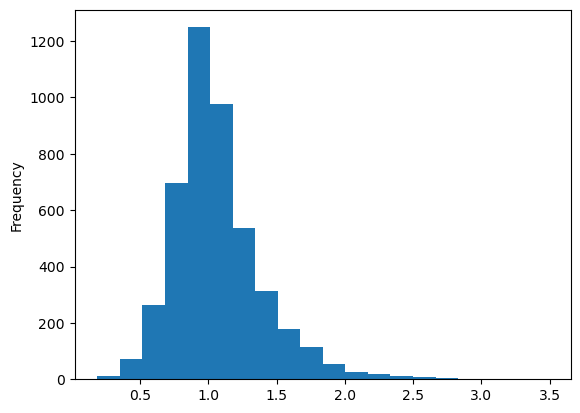

In [107]:
pomer.plot.hist(bins=20)

In [108]:
neutralita = pd.DataFrame(pomer).rename(columns={0:'cetnost'})
neutralita['odchylka'] = neutralita['cetnost'].apply(lambda x: x-1 if x>1 else 1-x)
neutralita.sort_values(by='odchylka').head(60)

,cetnost,odchylka
slova,,
když,1.000000,0.000000
ale,1.000000,0.000000
jako,1.000000,0.000000
být,1.000000,0.000000
možný,1.000156,0.000156
tak,0.999553,0.000447
odkládat,0.999553,0.000447
všechen,0.999553,0.000447
on,0.999553,0.000447


## Slova více používaná muži-spisovateli

In [110]:
pomer.sort_values(ascending=False).head(25)

slova
pistole          3.490503
prezident        3.219849
ruský            3.068803
kladivo          2.855866
nepříliš         2.799869
kulka            2.776536
vůl              2.751746
velet            2.697207
souboj           2.693031
politik          2.677374
střílet          2.663208
zaregistrovat    2.603003
ohrozit          2.589878
civilizace       2.542153
zvláště          2.512104
kapitán          2.502986
posléze          2.498883
hlídka           2.498883
služebný         2.498883
motor            2.473831
západní          2.468032
komín            2.445996
riziko           2.439385
vývoj            2.436552
technický        2.429469
dtype: float64

In [111]:
pomer[pomer.index.str.endswith('la')].sort_values()

slova
netušila      0.224767
zahlédla      0.244091
užívala       0.278498
nečekala      0.278893
lekla         0.283320
neuměla       0.303319
rozhlížela    0.319253
ucítila       0.322985
ptala         0.349223
nestihla      0.354451
přejela       0.376816
zadívala      0.383853
vyhrkla       0.388025
četla         0.392797
chystala      0.396648
ušklíbla      0.419980
nešla         0.428380
nalila        0.435345
chytla        0.439762
nechávala     0.442770
odložila      0.471020
strčila       0.471020
neřekla       0.471265
usmívala      0.471874
sklopila      0.488182
zamávala      0.495810
vzdychla      0.509976
mávla         0.549205
zasmála       0.549205
vyrazila      0.553073
odvětila      0.570182
odsekla       0.594972
zažila        0.628026
nepřišla      0.636482
přikývla      0.661080
jezdila       0.679968
pohladila     0.735602
dokola        0.783126
Hela          0.839961
stodola       0.861684
škola         0.887810
jehla         0.912291
docela        0.996705
síla 

## Slova více používaná ženami-spisovatelkami

Pleso vypadá spíš jako špatné lemma slova ples.

In [114]:
(1 / pomer).sort_values(ascending=False).head(25)

slova
babi           5.402414
netušila       4.449047
zahlédla       4.096831
užívala        3.590696
nečekala       3.585603
lekla          3.529577
pyžamo         3.514298
salát          3.361502
neuměla        3.296858
rozhlížela     3.132309
ucítila        3.096121
kamarádka      2.969327
ptala          2.863502
nestihla       2.821261
miminko        2.801252
obývací        2.669428
přejela        2.653818
objímat        2.630741
rande          2.619994
zadívala       2.605164
mamka          2.577152
vyhrkla        2.577152
četla          2.545844
chystala       2.521127
povytáhnout    2.456482
dtype: float64

## Graf

In [116]:
pomer_vsech.sample(20)

slova
spjelkavik             NaN
zkoprnět          1.006876
zašpiněné         1.189944
nitěmi                 NaN
omráčená          2.379888
hromovládcovy          NaN
znesvářit              NaN
solinem                NaN
tetřevně               NaN
ventilátorem           NaN
uetaduem               NaN
felaci                 NaN
posielanie             NaN
vyslanému              NaN
onta                   NaN
pomalovaná             NaN
výbušnost              NaN
poseče                 NaN
křivda            2.039904
prostranstvích    1.189944
dtype: float64

In [117]:
pomer.reset_index()

,slova,0
0,Adam,1.045708
1,Amerika,1.272963
2,Anglie,1.101800
3,Anna,1.054723
4,Brno,0.964820
...,...,...
4539,žádost,1.478415
4540,žák,1.294939
4541,žíla,1.363478
4542,žít,0.884095


In [118]:
import polars as pl

In [119]:
pomer

slova
Adam       1.045708
Amerika    1.272963
Anglie     1.101800
Anna       1.054723
Brno       0.964820
             ...   
žádost     1.478415
žák        1.294939
žíla       1.363478
žít        0.884095
žízeň      1.380335
Length: 4544, dtype: float64

In [120]:
pomer = pomer.reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})

In [121]:
pomer

,slovo,rozdíl
0,Adam,1.045708
1,Amerika,1.272963
2,Anglie,1.101800
3,Anna,1.054723
4,Brno,0.964820
...,...,...
4539,žádost,1.478415
4540,žák,1.294939
4541,žíla,1.363478
4542,žít,0.884095


,slovo,rozdíl


In [122]:
pomer_bez_a = pomer[pomer['slovo'].str[-2:] != 'la']
pomer_bez_a

,slovo,rozdíl
0,Adam,1.045708
1,Amerika,1.272963
2,Anglie,1.101800
3,Anna,1.054723
4,Brno,0.964820
...,...,...
4538,žádný,0.997143
4539,žádost,1.478415
4540,žák,1.294939
4542,žít,0.884095


In [123]:
problematicke = ['pleso','Karlov','podpatku']
pomer2 = pomer_bez_a
pomer2 = pomer2[~pomer2['slovo'].isin(problematicke)]
pomer2 = pomer2.groupby('slovo')['rozdíl'].first()
do_grafu = pd.concat([
    (1 / pomer2).sort_values(ascending=False).head(12),
    -pomer2.sort_values(ascending=False).head(12)
]).sort_values(ascending=False).reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})
do_grafu['mz'] = do_grafu['rozdíl'].apply(lambda x: 'mužští autoři' if x < 0 else 'ženské autorky')
do_grafu

,slovo,rozdíl,mz
0,babi,5.402414,ženské autorky
1,pyžamo,3.514298,ženské autorky
2,salát,3.361502,ženské autorky
3,kamarádka,2.969327,ženské autorky
4,miminko,2.801252,ženské autorky
5,obývací,2.669428,ženské autorky
6,objímat,2.630741,ženské autorky
7,rande,2.619994,ženské autorky
8,mamka,2.577152,ženské autorky
9,povytáhnout,2.456482,ženské autorky


In [124]:
do_grafu2 = do_grafu
do_grafu2['rozdíl'] = do_grafu2['rozdíl'].apply(lambda x: abs(x))
do_grafu2

,slovo,rozdíl,mz
0,babi,5.402414,ženské autorky
1,pyžamo,3.514298,ženské autorky
2,salát,3.361502,ženské autorky
3,kamarádka,2.969327,ženské autorky
4,miminko,2.801252,ženské autorky
5,obývací,2.669428,ženské autorky
6,objímat,2.630741,ženské autorky
7,rande,2.619994,ženské autorky
8,mamka,2.577152,ženské autorky
9,povytáhnout,2.456482,ženské autorky


In [125]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [126]:
def irozhlas_conf():

    return {
        "config" : {
             "title": {'font': "Noticia Text",
                      'fontSize': 14,
                      'anchor': 'start',
                       'fontWeight': 'bolder',
                    'subtitleFont': 'Noticia Text',
                      'subtitleFontSize': 12,
                       'subtitleFontWeight': 'lighter',
                      'subtitlePadding': 12,
                       'dy': -12,
                      },
             "axis": {
                "labelFont": "Asap",
                "titleFont": "Asap",
                 "fontWeight": "lighter",
                "titleFontWeight": "lighter",
                "labelFontSize": 10,
                "titleFontSize": 10,
                'labelPadding': 2,
                 'titlePadding': 10
            },
            "legend": {
                "labelFont": "Asap",
                "labelFontWeight": "normal",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 10,
                "titleFontSize": 10
            }
        }
    }

alt.themes.register('irozhlas', irozhlas_conf)
alt.themes.enable('irozhlas')

ThemeRegistry.enable('irozhlas')

In [127]:
from textwrap import wrap


In [129]:
titulek = ["Spisovatelky píšou častěji o ženách,","spisovatelé o střelbě"]
kredit = "zdroj dat: Česká národní bibliografie · vizualizace: iROZHLAS.cz · 2025"
podtitulek = f"Graf srovnává pouze slova, která se objevila alespoň v 50 prózách, vypadla tak například „erekce“, 9× častěji zmiňovaná muži. Do výsledku se nepromítá, zda se v ukázce slovo objevilo jednou, nebo víckrát."
podtitulek = wrap(podtitulek, 70)
info = [f"zdroj: {graf_rozsah} tisíc stran ukázek z próz {graf_zeny} českých autorek a {graf_muzi} autorů z let {graf_rok_min} a {graf_rok_max}", "data: Česká národní bibliografie, martinus.cz · vizualizace: iROZHLAS.cz · 2025"]

In [131]:
max_abs_value = max(abs(do_grafu['rozdíl'].max()), abs(do_grafu['rozdíl'].min()))

mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))

)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [133]:
# Chart for "mužští autoři"
muzsti_autori = alt.Chart(
    do_grafu2[do_grafu2["mz"] == "mužští autoři"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4'])),
).properties(title={"text": ["slova používanější","mužskými autory"], 'fontSize': 12}, width=120)

# Chart for "ženské autorky"
zenske_autorky = alt.Chart(
    do_grafu2[do_grafu2["mz"] == "ženské autorky"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#E7666E'])),
).properties(title={"text": ["slova používanější","ženskými autorkami"], 'fontSize': 12}, width=120)

# Combine the charts with shared x-axis scale and original title
mz_graf = alt.hconcat(
    zenske_autorky,
    muzsti_autori
).resolve_scale(
    x='shared',  # Ensures the x-axes share the same scale
    color='independent'  # Allows each chart to use its own color encoding
).properties(
    title={
        'text': titulek,
        'subtitle': podtitulek
    }
)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.

alt.HConcatChart(...)

In [ ]:
def me_to_neurazi(zaklad_grafu, soubor, kredity):

    os.makedirs("grafy", exist_ok=True)
    
    credits = pl.DataFrame({'text': [kredity]})
    credits = alt.Chart(credits.to_pandas()).encode(text=alt.Text('text:N')).mark_text(fontSize=10,font="Asap", baseline='line-bottom', align='right').properties(width=300)
    combined_chart = alt.vconcat(zaklad_grafu, credits).properties(background='cyan').configure_view(stroke='transparent')

    combined_chart.save(os.path.join("grafy",f"{soubor}.svg"))
    combined_chart.save(os.path.join("grafy",f"{soubor}.png"), ppi=400)
    
    return combined_chart

In [ ]:
def me_to_neurazi(zaklad_grafu, soubor, kredity):
    os.makedirs("grafy", exist_ok=True)

    credits = pl.DataFrame({'text': [kredity]})
    credits = alt.Chart(credits.to_pandas()).encode(
        text=alt.Text('text:N')
    ).mark_text(
        fontSize=10,
        font="Asap",
        baseline='line-bottom',
        align='right',
        dx=190  # Adjust dx to move the text to the right edge
    ).properties(width=300)

    combined_chart = alt.vconcat(zaklad_grafu, credits).configure_view(stroke='transparent') # .properties(background='cyan')

    combined_chart.save(os.path.join("grafy", f"{soubor}.svg"))
    combined_chart.save(os.path.join("grafy", f"{soubor}.png"), ppi=400)

    return combined_chart

In [ ]:
me_to_neurazi(mz_graf, "muzska_zenska_slova", info)

## Barvy

In [344]:
barvy = {
    'černý': '#000000',
    'bílý': '#FFFFFF',
    'červený': '#FF0000',
    'zelený': '#00FF00',
    'modrý': '#0000FF',
    'žlutý': '#FFFF00',
    'fialový': '#800080',
    'tyrkysový': '#00FFFF',
    'oranžový': '#FFA500',
    'růžový': '#FFC0CB',
    'béžový': None,
    'sépiový': None,
    'starorůžový': None,
    'hnědý': None,
    'rudý': None,
    'šedý': None,
    'purpurový': None,
    'karmínový': None,
    'kobaltový': None,
    'meruňkový': None,
    'šarlatový': None,
    'ultramarínový': None,
    'vínový': None,
    'khaki': None,
    'indigový': None,
    'nachový': None,
    'sivý': None
}

In [346]:
cetnost_barev = {}
for barva, kod in barvy.items():
    cetnost_barev[barva] = pomer_vsech[pomer_vsech.index == barva].max()
pd.Series(cetnost_barev).sort_values()

purpurový        0.237989
tyrkysový        0.366137
růžový           0.507189
oranžový         0.713966
modrý            0.746420
béžový           0.747965
karmínový        0.849960
nachový          0.849960
hnědý            0.862278
fialový          0.863293
žlutý            0.871942
rudý             0.889189
červený          0.912089
černý            0.912941
zelený           0.917957
šedý             0.942683
bílý             0.958314
khaki            1.784916
šarlatový        2.379888
sépiový               NaN
starorůžový           NaN
kobaltový             NaN
meruňkový             NaN
ultramarínový         NaN
vínový                NaN
indigový              NaN
sivý                  NaN
dtype: float64

In [314]:
pomer_vsech[pomer_vsech.index.str.contains('fialov')]

slova
fialova                NaN
fialovohnědý           NaN
fialovomodrý           NaN
fialovoocí             NaN
fialovooký             NaN
fialovookými           NaN
fialovorůžový          NaN
fialovočerný           NaN
fialovožluta           NaN
fialovožlutý           NaN
fialovym               NaN
fialový           0.863293
fialově           0.594972
modrofialova           NaN
modrofialový      1.784916
nafialovělá            NaN
nafialovělé            NaN
nafialovělých          NaN
nafialovělými          NaN
tmavofialový           NaN
ultrafialový           NaN
zfialověl         1.189944
červenofialový         NaN
šedofialový            NaN
dtype: float64

In [294]:
pomer_vsech

slova
Abraham     3.569832
Abrahám     1.189944
Achilles         NaN
Adam        1.045708
Adamec      1.189944
              ...   
שקרן             NaN
 září            NaN
  pátek          NaN
 který           NaN
 patro           NaN
Length: 153581, dtype: float64